## Homework 3 MAE-207

In [1]:
import time
from IPython.display import clear_output
import numpy as np
import matplotlib as mpl

# import sympy
from sympy import symbols, pprint
from sympy import sin, cos, asin, acos, atan, pi, sqrt
from sympy import Matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sympy import lambdify
# import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

from IPython import display # for the animation
# import matplotlib as mpl
# mpl.use('Qt5Agg')
# plt.ion()
import os
import matplotlib.pyplot as plt
# plt.ion()

# for the symbolic manipulation of jacobian
import sympy as sp
# from sympy import symbols
#from sympy import sin, cos, asin, acos, pi, atan2, sqrt
from sympy.utilities.lambdify import lambdify
#from sympy import Matrix

from scipy.optimize import minimize
from scipy.optimize import fsolve

import time

import odrive
from odrive.utils import *
import odrive.enums
%matplotlib qt

## Connect to ODrive

In [2]:
odrv0 = odrive.find_any()
if odrv0 is not None:
    print('Connected!')
    print('Odrive serial {}'.format(odrv0.serial_number))
    
    m0 = odrv0.axis0.motor.is_calibrated
    m1 = odrv0.axis1.motor.is_calibrated
    
    print('Motor 0 calibrated: {}'.format(m0))
    print('Motor 1 calibrated: {}'.format(m1))    
    
else:
    print('Not connected')
    

Connected!
Odrive serial 53194131976757
Motor 0 calibrated: True
Motor 1 calibrated: True


In [4]:
m0 = odrv0.axis0.motor.is_calibrated
m1 = odrv0.axis1.motor.is_calibrated
    
print('Motor 0 calibrated: {}'.format(m0))
print('Motor 1 calibrated: {}'.format(m1))

Motor 0 calibrated: True
Motor 1 calibrated: True


#### Setting the velocity and calibration current limit

In [3]:

odrv0.axis0.controller.config.vel_limit=200000
odrv0.axis1.controller.config.vel_limit=200000
odrv0.axis0.motor.config.calibration_current=20.0
odrv0.axis1.motor.config.calibration_current=20.0


odrv0.axis0.controller.config.vel_gain = 16 / 10000.0
odrv0.axis1.controller.config.vel_gain = 16 / 10000.0
odrv0.axis1.controller.config.pos_gain=44
odrv0.axis1.controller.config.pos_gain=44

odrv0.axis0.controller.config.vel_integrator_gain = 0.001 #/ 10000.0
odrv0.axis1.controller.config.vel_integrator_gain = 0.001 #5.0 / 10000.0


#### Calibrating the Motors

In [33]:
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_FULL_CALIBRATION_SEQUENCE

time.sleep(15)

print('\t Motor 0 calibration result: {} \r\n'.format(odrv0.axis0.motor.is_calibrated), 
      '\t Motor 1 calibration result: {}'.format(odrv0.axis1.motor.is_calibrated))


	 Motor 0 calibration result: True 
 	 Motor 1 calibration result: True


#### Function to make the motors return to idle mode 

In [5]:
# Function to make the motors return to idle mode 
def motor_idle(): 
    odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
    odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

In [6]:
# Defining the Symbols
(theta_l, 
 theta_r,
 l1, 
 l2,
 w) = symbols(""" theta_l
                         theta_r
                         l1 
                         l2
                         w """ , real = True)

#### Forward Kinematics definition

In [7]:
A = 2*l2*l1*sin(theta_l)- 2*l1*l2*sin(theta_r)
B = 2*l2*w - 2*l1*l2*cos(theta_r) + 2*l2*l1*cos(theta_l)
C = 2*(l1**2) + w**2 - 2*l1*l1*sin(theta_l)*sin(theta_r) - 2*l1*w*cos(theta_r) + 2*l1*w*cos(theta_l) - 2*l1*l1*cos(theta_l)*cos(theta_r)

theta3_1 = 2*atan((A + sqrt(A**2 + B**2 - C**2))/(B-C))
theta3_2 = 2*atan((A - sqrt(A**2 + B**2 - C**2))/(B-C))

xc_1 = l1*cos(theta_l) + l2*cos(theta3_1) + w/2
xc_1
xc_2 = l1*cos(theta_l) + l2*cos(theta3_2) + w/2
xc_2

yc_1 = l1*sin(theta_l) + l2*sin(theta3_1)
yc_1
yc_2 = l1*sin(theta_l) + l2*sin(theta3_2)
yc_2
#sympy.simplify(theta3_1)
#sympy.simplify(theta3_2)

l1*cos(theta_l) + l2*cos(2*atan((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r) + sqrt((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r))**2 + (2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) + 2*l2*w)**2 - (-2*l1**2*sin(theta_l)*sin(theta_r) - 2*l1**2*cos(theta_l)*cos(theta_r) + 2*l1**2 + 2*l1*w*cos(theta_l) - 2*l1*w*cos(theta_r) + w**2)**2))/(2*l1**2*sin(theta_l)*sin(theta_r) + 2*l1**2*cos(theta_l)*cos(theta_r) - 2*l1**2 + 2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) - 2*l1*w*cos(theta_l) + 2*l1*w*cos(theta_r) + 2*l2*w - w**2))) + w/2

l1*cos(theta_l) + l2*cos(2*atan((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r) - sqrt((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r))**2 + (2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) + 2*l2*w)**2 - (-2*l1**2*sin(theta_l)*sin(theta_r) - 2*l1**2*cos(theta_l)*cos(theta_r) + 2*l1**2 + 2*l1*w*cos(theta_l) - 2*l1*w*cos(theta_r) + w**2)**2))/(2*l1**2*sin(theta_l)*sin(theta_r) + 2*l1**2*cos(theta_l)*cos(theta_r) - 2*l1**2 + 2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) - 2*l1*w*cos(theta_l) + 2*l1*w*cos(theta_r) + 2*l2*w - w**2))) + w/2

l1*sin(theta_l) + l2*sin(2*atan((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r) + sqrt((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r))**2 + (2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) + 2*l2*w)**2 - (-2*l1**2*sin(theta_l)*sin(theta_r) - 2*l1**2*cos(theta_l)*cos(theta_r) + 2*l1**2 + 2*l1*w*cos(theta_l) - 2*l1*w*cos(theta_r) + w**2)**2))/(2*l1**2*sin(theta_l)*sin(theta_r) + 2*l1**2*cos(theta_l)*cos(theta_r) - 2*l1**2 + 2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) - 2*l1*w*cos(theta_l) + 2*l1*w*cos(theta_r) + 2*l2*w - w**2)))

l1*sin(theta_l) + l2*sin(2*atan((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r) - sqrt((2*l1*l2*sin(theta_l) - 2*l1*l2*sin(theta_r))**2 + (2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) + 2*l2*w)**2 - (-2*l1**2*sin(theta_l)*sin(theta_r) - 2*l1**2*cos(theta_l)*cos(theta_r) + 2*l1**2 + 2*l1*w*cos(theta_l) - 2*l1*w*cos(theta_r) + w**2)**2))/(2*l1**2*sin(theta_l)*sin(theta_r) + 2*l1**2*cos(theta_l)*cos(theta_r) - 2*l1**2 + 2*l1*l2*cos(theta_l) - 2*l1*l2*cos(theta_r) - 2*l1*w*cos(theta_l) + 2*l1*w*cos(theta_r) + 2*l2*w - w**2)))

In [8]:
FK1 = Matrix([[xc_1],
             [yc_1]])
FK2 = Matrix([[xc_2],
             [yc_2]])

In [9]:
FK1_fast = lambdify((theta_l,theta_r,l1,l2,w),FK1)
FK2_fast = lambdify((theta_l,theta_r,l1,l2,w),FK2)

#### Function to setup the Home Position

In [10]:
# Function to setup home position
def autohome():
    print('Bring motors to home and press ENTER')
    input("<enter>")
    R_pos1=odrv0.axis0.encoder.pos_estimate
    L_pos1=odrv0.axis1.encoder.pos_estimate
    print('Bring motors to 90-90 and press ENTER')
    input("<enter>")
    R_pos2=odrv0.axis0.encoder.pos_estimate
    L_pos2=odrv0.axis1.encoder.pos_estimate
    ML_para=(90/(L_pos2-L_pos1))
    MR_para=((-90)/(R_pos2-R_pos1))
    print(ML_para)
    print(MR_para)
    print(L_pos2, L_pos1, R_pos2, R_pos1)
    print("Done")
    return ML_para,MR_para,L_pos1,R_pos1

#### Code to check the home position and record angle data (if needed)

In [11]:
theta=[]
cal_para=autohome()
while True:
    theta_R=(np.around(odrv0.axis0.encoder.pos_estimate)-cal_para[3])*(cal_para[1])+180
    theta_L=((np.around(odrv0.axis1.encoder.pos_estimate)-cal_para[2])*cal_para[0])
    print(theta_L, theta_R)
    clear_output()
#     os.system('cls')

    theta.append([theta_R,theta_L])
    
# Angle_value = np.asarray(theta)
# np.save('Angle_Workspace',Angle_value)

90.01136537050378 89.98919065443098


KeyboardInterrupt: 

#### Function to implement Inverse Kinematics using Minimize function

In [12]:
l1 = 0.09;                   
l2 = 0.16;                 
w = 0.07;  
def IK_5_link(x, y, l1 = l1, l2 = l2, w = w):
    
    def leg_wide(var):
        return np.linalg.norm([var[1] - np.pi, var[0]])
    
    def x_constraint_equation(var):
        return l1**2 - l2**2 + (x - w/2)**2 + y**2 - 2*l1*(y*np.sin(var[0]) + (x - w/2)*np.cos(var[0]))

    def y_constraint_equation(var):
        return l1**2 - l2**2 + (x + w/2)**2 + y**2 - 2*l1*(y*np.sin(var[1]) + (x + w/2)*np.cos(var[1]))

    
    res = minimize(leg_wide, (0.1, 9*np.pi/10), method="SLSQP", constraints= ({"type": "eq", "fun": x_constraint_equation}, 
                                                                               {"type": "eq", "fun": y_constraint_equation}))
    
    return (res, np.linalg.norm([x_constraint_equation(res.x), y_constraint_equation(res.x)]))

#### Code to implement the GAITs provided to us. 
This function returns a list of $\theta_L$ and $\theta_R$ for a giveb gait trajctory. These are later used to make the leg move in the desired trajectory

In [13]:
def get_trajectory(x,y,d,T,N):
    
    theta_points = []
    # Stance
    z = np.polyfit([x[0],x[1]],[y[0],y[1]],1)
    p = np.poly1d(z)
    n_stance = (np.rint(N*d))
    n_stance = n_stance.astype(int)
    x_stancepoints = np.linspace(x[0],x[1],n_stance+1)
    y_stancepoints = p(x_stancepoints)
    
    # Swing
    z = np.polyfit(x,y,2)
    p = np.poly1d(z)
    n_swing = np.rint((N*(1-d)))
    n_swing = n_swing.astype(int)
    x_swingpoints = np.linspace(x[1],x[0],n_swing+1)
    y_swingpoints = p(x_swingpoints)
    
    x_points = np.append(x_stancepoints,x_swingpoints[1:])
    y_points = np.append(y_stancepoints,y_swingpoints[1:])
    
    t_points = np.linspace(0,T,N+1)
    
    for i in range(x_points.shape[0]):
        
        res = IK_5_link(x_points[i],y_points[i])
        theta_points.append([res[0].x[1],res[0].x[0]])
    
    return theta_points,t_points

In [14]:
x = np.array([0.11,-0.11,0])
y = np.array([0.12+0.05,0.12+0.05,0.05+0.05])

data1, t1_points = get_trajectory(x,y,0.5,0.25,100)

x = np.array([0.11-0.05,-0.08-0.05,0.05-0.05])
y = np.array([0.14+0.05,0.1+0.05,0.05+0.05])

data2, t2_points = get_trajectory(x,y,0.75,0.5,100)

x = np.array([0.08,-0.08,0])
y = np.array([0.1+0.05,0.1+0.05,0.04+0.05])

data3, t3_points = get_trajectory(x,y,0.5,1.5,200)

#### Store the $\theta_L$ and $\theta_R$ to a numpy file to plot the data

In [15]:
np.save('theta_values_Data_2',data1)
np.save('theta_data3',data2)
np.save('theta_data4',data3)

#### Code to implement the parabolic gait trajectories (using angle evaluted from IK module above) and store the real motor angles to plot later
This code is ran 3 times for each $\theta_L$ and $\theta_R$ pertaining to each case i.e. 1,2 and 3.

In [16]:
theta_Gait=[]
odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_CLOSED_LOOP_CONTROL
a=np.load('data3_new3.npy')
start_time = time.time()
# your code
cpr= 2048
t_step = 0.005
w_r = 0
w_l = 0
for k in range(0,10):
    for i in range(0,len(a)):
        start_time2 = time.time()
        L_pos=(np.rad2deg(a[i][1] )/cal_para[0])+cal_para[2]
        R_pos=((np.rad2deg(a[i][0] )-180)/cal_para[1])+cal_para[3]
        if (i-1)>0:
            w_r = ((a[i][0] - a[i-1][0])/(t_step*2*np.pi) )*cpr
            w_l = ((a[i][1] - a[i-1][1])/(t_step*2*np.pi) )*cpr
        odrv0.axis0.controller.set_pos_setpoint(R_pos,1*w_r,0)
        odrv0.axis1.controller.set_pos_setpoint(L_pos,1*w_l,0)
        while (time.time() - start_time2 < 0.2*t_step):
            pass
            #clear_output()
#         time.sleep(0.1)
        theta_R=(np.around(odrv0.axis0.encoder.pos_estimate)-cal_para[3])*(cal_para[1])+180
        theta_L=((np.around(odrv0.axis1.encoder.pos_estimate)-cal_para[2])*cal_para[0])
        theta_Gait.append([theta_R,theta_L])
# motor_idle()    
elapsed_time = time.time() - start_time
print(elapsed_time)

4.075995922088623


In [98]:
np.save('theta_data3.npy',theta_Gait)

In [15]:
# Actual theta
theta_Gait1=np.load('theta_values_Data_2.npy')
theta_Gait2=np.load('theta_data3.npy')
theta_Gait3=np.load('theta_data4.npy')

In [16]:
# Calculated from IK
theta_cal1=np.load('data2.npy')
theta_cal2=np.load('data3_new3.npy')
theta_cal3=np.load('data4.npy')

#### Plotting the variatio of $\theta_L$ and $\theta_R$

In [17]:
a1=theta_cal1
b1=theta_cal2
c1=theta_cal3
for i in range(0,9):
    a1=np.concatenate((a1,theta_cal1),axis=0) 
    b1=np.concatenate((b1,theta_cal2),axis=0)
    c1=np.concatenate((c1,theta_cal3),axis=0)

Text(0.5, 0, '$t$')

Text(0, 0.5, '$\\theta_R$')

Text(0.5, 1.0, '$\\theta_R$ variation plot CASE1')

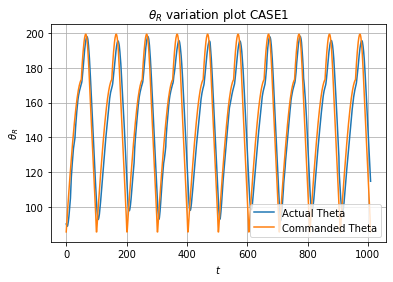

Text(0.5, 0, '$t$')

Text(0, 0.5, '$\\theta_L$')

Text(0.5, 1.0, '$\\theta_L$ variation plot CASE:1')

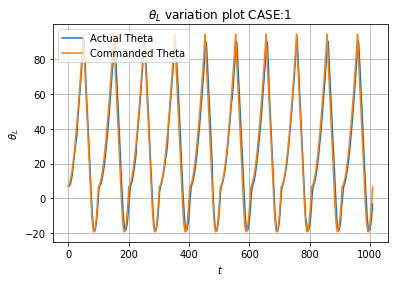

In [18]:
%matplotlib inline
plt.plot(theta_Gait1[:,0])
plt.plot(np.rad2deg(a1[:,0]))
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta_R$')
plt.title(r'$\theta_R$ variation plot CASE1')
# plt.gca().set_aspect('equal')
plt.grid()
plt.legend(['Actual Theta','Commanded Theta'])
plt.show()

plt.plot(theta_Gait1[:,1])
plt.plot(np.rad2deg(a1[:,1]))
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta_L$')
plt.title(r'$\theta_L$ variation plot CASE:1')
plt.legend(['Actual Theta','Commanded Theta'])
# plt.gca().set_aspect('equal')
plt.grid()

Text(0.5, 0, '$t$')

Text(0, 0.5, '$\\theta_R$')

Text(0.5, 1.0, '$\\theta_R$ variation plot CASE:2')

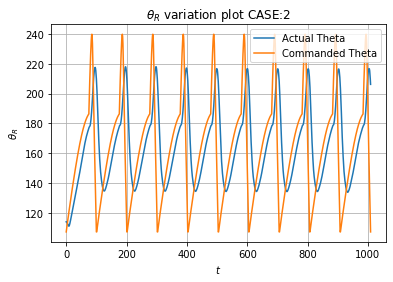

Text(0.5, 0, '$t$')

Text(0, 0.5, '$\\theta_L$')

Text(0.5, 1.0, '$\\theta_L$ variation plot CASE:2')

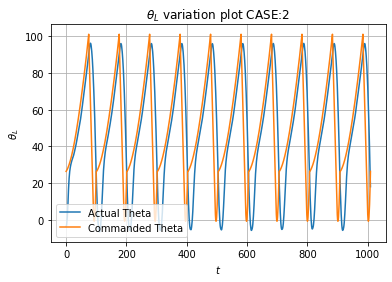

In [19]:
%matplotlib inline
plt.plot(theta_Gait2[:,0])
plt.plot(np.rad2deg(b1[:,0]))
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta_R$')
plt.title(r'$\theta_R$ variation plot CASE:2')
plt.legend(['Actual Theta','Commanded Theta'])
# plt.gca().set_aspect('equal')
plt.grid()
plt.show()

plt.plot(theta_Gait2[:,1])
plt.plot(np.rad2deg(b1[:,1]))
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta_L$')
plt.title(r'$\theta_L$ variation plot CASE:2')
plt.legend(['Actual Theta','Commanded Theta'])
# plt.gca().set_aspect('equal')
plt.grid()

Text(0.5, 0, '$t$')

Text(0, 0.5, '$\\theta_R$')

Text(0.5, 1.0, '$\\theta_R$ variation plot CASE:3')

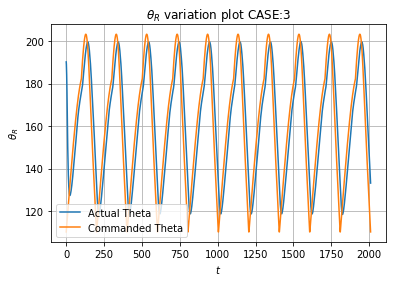

Text(0.5, 0, '$t$')

Text(0, 0.5, '$\\theta_L$')

Text(0.5, 1.0, '$\\theta_L$ variation plot CASE:3')

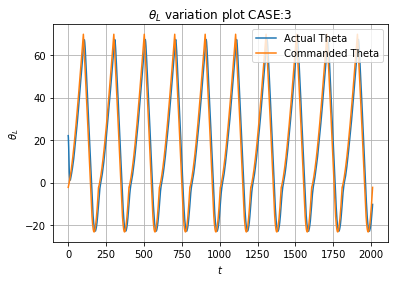

In [20]:
%matplotlib inline
plt.plot(theta_Gait3[:,0])
plt.plot(np.rad2deg(c1[:,0]))
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta_R$')
plt.title(r'$\theta_R$ variation plot CASE:3')
plt.legend(['Actual Theta','Commanded Theta'])
# plt.gca().set_aspect('equal')
plt.grid()
plt.show()

plt.plot(theta_Gait3[:,1])
plt.plot(np.rad2deg(c1[:,1]))
plt.xlabel(r'$t$')
plt.ylabel(r'$\theta_L$')
plt.title(r'$\theta_L$ variation plot CASE:3')
plt.legend(['Actual Theta','Commanded Theta'])
# plt.gca().set_aspect('equal')
plt.grid()

#### Plotting the ($\theta_L$, $\theta_R$) Workspace.

Text(0.5, 0, '$\\theta_R$')

Text(0, 0.5, '$\\theta_L$')

Text(0.5, 1.0, 'Angle workspace plot CASE:1')

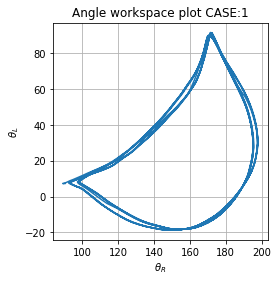

Text(0.5, 0, '$\\theta_R$')

Text(0, 0.5, '$\\theta_L$')

Text(0.5, 1.0, 'Angle workspace plot CASE:2')

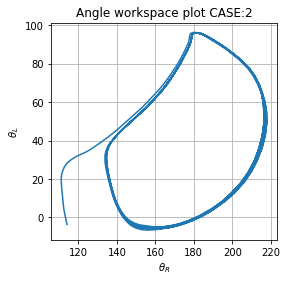

Text(0.5, 0, '$\\theta_R$')

Text(0, 0.5, '$\\theta_L$')

Text(0.5, 1.0, 'Angle workspace plot CASE:3')

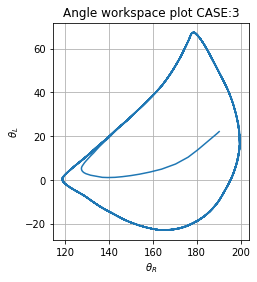

In [139]:
plt.plot(*zip(*theta_Gait1))
plt.xlabel(r'$\theta_R$')
plt.ylabel(r'$\theta_L$')
plt.title('Angle workspace plot CASE:1')
plt.gca().set_aspect('equal')
plt.grid()
plt.show()

plt.plot(*zip(*theta_Gait2))
plt.xlabel(r'$\theta_R$')
plt.ylabel(r'$\theta_L$')
plt.title('Angle workspace plot CASE:2')
plt.gca().set_aspect('equal')
plt.grid()
plt.show()

plt.plot(*zip(*theta_Gait3))
plt.xlabel(r'$\theta_R$')
plt.ylabel(r'$\theta_L$')
plt.title('Angle workspace plot CASE:3')
plt.gca().set_aspect('equal')
plt.grid()

#### Plotting the ($x,y$) coordinate Workspace

Text(0.5, 0, '$X$')

Text(0, 0.5, '$Y$')

Text(0.5, 1.0, '(X,Y) workspace plot CASE:1')

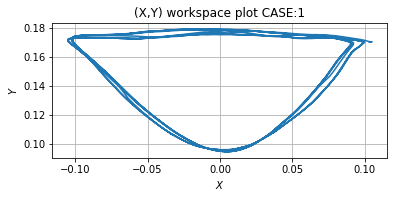

In [11]:
data_pointsFK1 = np.zeros([1,2])
data_pointsFK2 = np.zeros([1,2])
# for i in [1,2,3]

theta=theta_Gait1
for k in range(0,len(theta)):
    
    data_pointsFK1 = np.append(data_pointsFK1,FK1_fast(np.radians(theta[k][1]),np.radians(theta[k][0]),0.09,0.16,0.07).T,axis=0)
#     data_pointsFK2 = np.append(data_pointsFK2,FK2_fast(np.radians(theta[k][1]),np.radians(theta[k][0]),0.09,0.16,0.07).T,axis=0)
# data_pointsFK1.shape                               
data_pointsFK1 = data_pointsFK1[1:data_pointsFK1.shape[0],:]
# data_pointsFK2 = data_pointsFK2[1:data_pointsFK2.shape[0],:]

plt.clf()
plt.plot(data_pointsFK1[:,0],data_pointsFK1[:,1])
# plt.plot(data_pointsFK2[:,0],data_pointsFK2[:,1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('(X,Y) workspace plot CASE:1')
plt.grid()
plt.gca().set_aspect('equal')

Text(0.5, 0, '$X$')

Text(0, 0.5, '$Y$')

Text(0.5, 1.0, '(X,Y) workspace plot CASE:2')

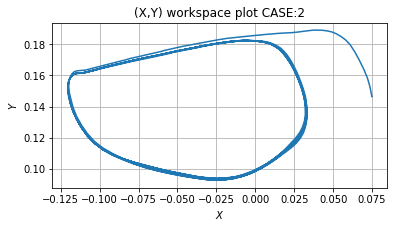

In [12]:
data_pointsFK1 = np.zeros([1,2])
data_pointsFK2 = np.zeros([1,2])
# for i in [1,2,3]

theta=theta_Gait2
for k in range(0,len(theta)):
    
    data_pointsFK1 = np.append(data_pointsFK1,FK1_fast(np.radians(theta[k][1]),np.radians(theta[k][0]),0.09,0.16,0.07).T,axis=0)
#     data_pointsFK2 = np.append(data_pointsFK2,FK2_fast(np.radians(theta[k][1]),np.radians(theta[k][0]),0.09,0.16,0.07).T,axis=0)
# data_pointsFK1.shape                               
data_pointsFK1 = data_pointsFK1[1:data_pointsFK1.shape[0],:]
# data_pointsFK2 = data_pointsFK2[1:data_pointsFK2.shape[0],:]

plt.clf()
plt.plot(data_pointsFK1[:,0],data_pointsFK1[:,1])
# plt.plot(data_pointsFK2[:,0],data_pointsFK2[:,1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('(X,Y) workspace plot CASE:2')
plt.grid()
plt.gca().set_aspect('equal')

Text(0.5, 0, '$X$')

Text(0, 0.5, '$Y$')

Text(0.5, 1.0, '(X,Y) workspace plot CASE:3')

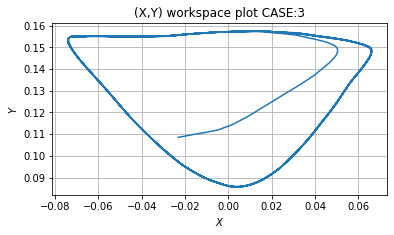

In [13]:
data_pointsFK1 = np.zeros([1,2])
data_pointsFK2 = np.zeros([1,2])
# for i in [1,2,3]

theta=theta_Gait3
for k in range(0,len(theta)):
    
    data_pointsFK1 = np.append(data_pointsFK1,FK1_fast(np.radians(theta[k][1]),np.radians(theta[k][0]),0.09,0.16,0.07).T,axis=0)
#     data_pointsFK2 = np.append(data_pointsFK2,FK2_fast(np.radians(theta[k][1]),np.radians(theta[k][0]),0.09,0.16,0.07).T,axis=0)
# data_pointsFK1.shape                               
data_pointsFK1 = data_pointsFK1[1:data_pointsFK1.shape[0],:]
# data_pointsFK2 = data_pointsFK2[1:data_pointsFK2.shape[0],:]

plt.clf()
plt.plot(data_pointsFK1[:,0],data_pointsFK1[:,1])
# plt.plot(data_pointsFK2[:,0],data_pointsFK2[:,1])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title('(X,Y) workspace plot CASE:3')
plt.grid()
plt.gca().set_aspect('equal')